# Study geometry handling
Check if the tools used to handle the geometry are good enough

## TODO
- ?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batoid

from ghosts import plotter
from ghosts import  simulator
from ghosts import tweak_optics

from ghosts.analysis import compute_ghost_separations, reduce_ghosts
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_2, FAST_BEAM_CONFIG_1

from ghosts import geom
from ghosts.geom_config import GEOM_CONFIG_0

In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 36000 pixels per mm^2


In [4]:
# build the standard telescope from GEOM_CONFIG_0
telescope = tweak_optics.build_telescope_from_geom(GEOM_CONFIG_0)

Direct path is number 28
  central impact point is (0.099481, 0.000011)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 662.8167


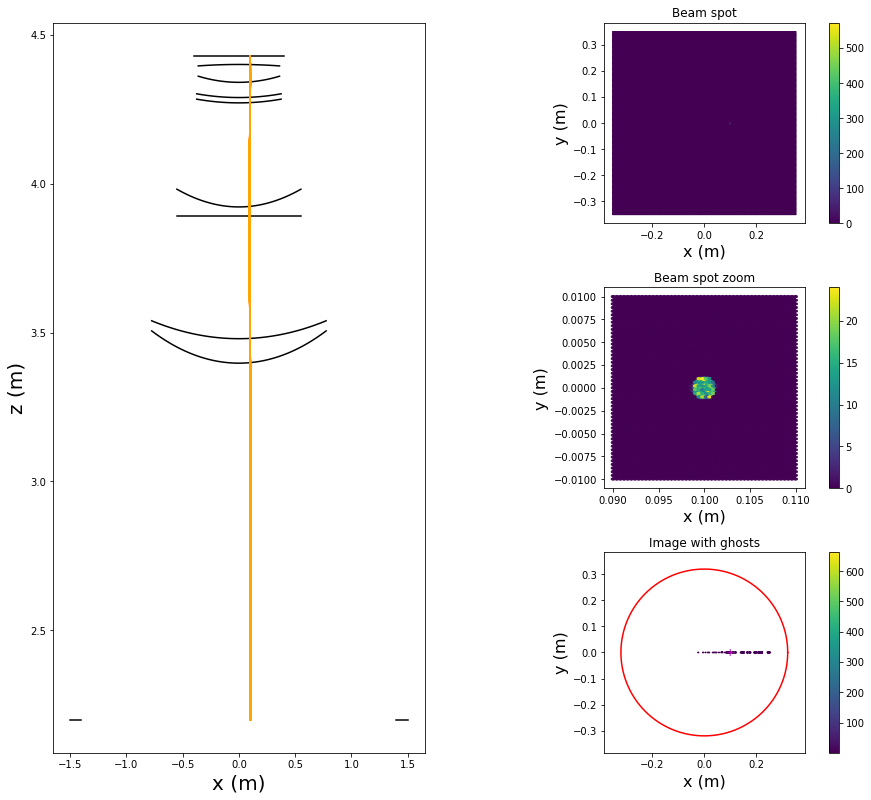

0

In [5]:
# Run simulation with standard beam config
traceFull, rForward, rReverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_1)
simulation = [traceFull, rForward, rReverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)


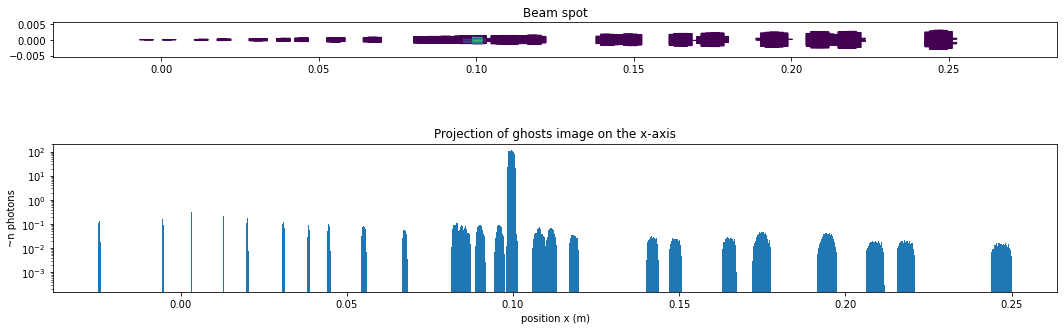

0

In [6]:
# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward)

In [7]:
# Analyze reference set of beam spots
ref_spots_data, _ref_spots = reduce_ghosts(rForward)
ref_data_frame = make_data_frame(ref_spots_data, BEAM_CONFIG_1['beam_id'], GEOM_CONFIG_0['geom_id'])
ref_data_frame.sort_values(by=['name'])

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,pixel_signal
33,1,0,33,"(Detector, Filter_entrance)",0.085096,0.000541,9.063267e-06,0.000541,0.002100,0.002086,0.002093,0.000007,0.295428,13.763425,127.565809
34,1,0,34,"(Detector, Filter_exit)",0.086244,0.000548,9.185499e-06,0.000548,0.002129,0.002114,0.002121,0.000008,0.307609,14.137714,129.309220
29,1,0,29,"(Detector, L1_entrance)",-0.005197,0.000035,-5.531673e-07,0.000035,0.000136,0.000127,0.000132,0.000004,0.251339,0.054629,27342.926760
30,1,0,30,"(Detector, L1_exit)",0.038539,0.000244,4.104723e-06,0.000244,0.000949,0.000945,0.000947,0.000002,0.261702,2.815841,552.343464
31,1,0,31,"(Detector, L2_entrance)",0.082554,0.000524,8.792653e-06,0.000524,0.002035,0.002023,0.002029,0.000006,0.272493,12.937711,125.172140
32,1,0,32,"(Detector, L2_exit)",0.030907,0.000196,3.291887e-06,0.000196,0.000760,0.000758,0.000759,0.000001,0.283729,1.808043,932.618958
35,1,0,35,"(Detector, L3_entrance)",0.090445,0.000576,9.632743e-06,0.000576,0.002237,0.002217,0.002227,0.000010,0.320293,15.581175,122.167676
36,1,0,36,"(Detector, L3_exit)",0.099164,0.000630,1.056152e-05,0.000630,0.002449,0.002431,0.002440,0.000009,0.333499,18.700118,105.988811
10,1,0,10,"(Filter_entrance, L1_entrance)",0.111203,0.000707,1.184371e-05,0.000707,0.002748,0.002726,0.002737,0.000011,0.295428,23.532833,74.608207
11,1,0,11,"(Filter_entrance, L1_exit)",0.193997,0.001233,2.066185e-05,0.001233,0.004791,0.004755,0.004773,0.000018,0.307609,71.565905,25.544800


Now the exercise consists in building several geometries, store these in a panda data frame, and then produce simulations from the data frame

In [8]:
def run_and_analyze_simulation_for_geom_frame(geom_data_frame, beam_config=BEAM_CONFIG_1):
    # define outputs
    beam_spots = list()
    # list of unique geom ids
    geom_id_set = set(geom_data_frame['geom_id'])
    # loop on geom ids
    for geom_id in geom_id_set:
        # get geom config as a dictionary for the geom id
        geom_config = geom.to_dict(geom_data_frame[geom_data_frame['geom_id']==geom_id])
        # build the standard telescope from GEOM_CONFIG_0
        telescope = tweak_optics.build_telescope_from_geom(geom_config)
        # run simulation
        print(f'Run simulation for geom id: {geom_id}')
        trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=beam_config)
        simulation = [trace_full, r_forward, r_reverse, rays]
        # analyze beam spots
        spots_data, _spots = reduce_ghosts(r_forward)
        spots_data_frame = make_data_frame(spots_data, beam_config['beam_id'], geom_id)
        data = (geom_id, spots_data_frame)
        beam_spots.append(data)
    # return the set of beam spots and the geom id
    return beam_spots

In [9]:
my_shifts = [dx*0.01 for dx in range(-10, 11)]
g = geom.build_translation_set('L1', 'x', my_shifts, 10000)

In [10]:
frame = geom.concat_dicts(g)
frame.tail()


,geom_id,L1_dx,L1_dy,L1_dz,L1_rx,L1_ry,L1_rz,L2_dx,L2_dy,L2_dz,...,Filter_dz,Filter_rx,Filter_ry,Filter_rz,Detector_dx,Detector_dy,Detector_dz,Detector_rx,Detector_ry,Detector_rz
10016,10016,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10017,10017,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10018,10018,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10019,10019,0.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10020,10020,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
one = frame[frame['geom_id']==10015]
one

,geom_id,L1_dx,L1_dy,L1_dz,L1_rx,L1_ry,L1_rz,L2_dx,L2_dy,L2_dz,...,Filter_dz,Filter_rx,Filter_ry,Filter_rz,Detector_dx,Detector_dy,Detector_dz,Detector_rx,Detector_ry,Detector_rz
10015,10015,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
geom.to_dict(one)

{'geom_id': 10015,
 'L1_dx': 0.05,
 'L1_dy': 0.0,
 'L1_dz': 0.0,
 'L1_rx': 0.0,
 'L1_ry': 0.0,
 'L1_rz': 0.0,
 'L2_dx': 0.0,
 'L2_dy': 0.0,
 'L2_dz': 0.0,
 'L2_rx': 0.0,
 'L2_ry': 0.0,
 'L2_rz': 0.0,
 'L3_dx': 0.0,
 'L3_dy': 0.0,
 'L3_dz': 0.0,
 'L3_rx': 0.0,
 'L3_ry': 0.0,
 'L3_rz': 0.0,
 'Filter_dx': 0.0,
 'Filter_dy': 0.0,
 'Filter_dz': 0.0,
 'Filter_rx': 0.0,
 'Filter_ry': 0.0,
 'Filter_rz': 0.0,
 'Detector_dx': 0.0,
 'Detector_dy': 0.0,
 'Detector_dz': 0.0,
 'Detector_rx': 0.0,
 'Detector_ry': 0.0,
 'Detector_rz': 0.0}

In [13]:
geom_id_set = set(frame['geom_id'])

In [14]:
# run simulations for the set of geometries
beam_spots = run_and_analyze_simulation_for_geom_frame(frame, beam_config=BEAM_CONFIG_1)

Run simulation for geom id: 10000
Run simulation for geom id: 10001
Run simulation for geom id: 10002
Run simulation for geom id: 10003
Run simulation for geom id: 10004
Run simulation for geom id: 10005
Run simulation for geom id: 10006
Run simulation for geom id: 10007
Run simulation for geom id: 10008
Run simulation for geom id: 10009
Run simulation for geom id: 10010
Run simulation for geom id: 10011
Run simulation for geom id: 10012
Run simulation for geom id: 10013
Run simulation for geom id: 10014
Run simulation for geom id: 10015
Run simulation for geom id: 10016
Run simulation for geom id: 10017
Run simulation for geom id: 10018
Run simulation for geom id: 10019
Run simulation for geom id: 10020


In [15]:
# Compute distances for each frame
distances_2d = list()
distances_3d = list()
my_geom_ids = list()
for one in beam_spots:
    geom_id = one[0]
    df_i = one[1]
    my_geom_ids.append(geom_id)
    match_ref = match_ghosts(ref_data_frame, df_i)
    distances_2d.append(compute_2d_reduced_distance(match_ref))
    distances_3d.append(compute_reduced_distance(match_ref))


(<Figure size 1296x648 with 2 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:title={'center':'Rotation scan from 10000.000 to 10020.000 degrees'}, xlabel='rotation angle degrees', ylabel='distance'>],
       dtype=object))

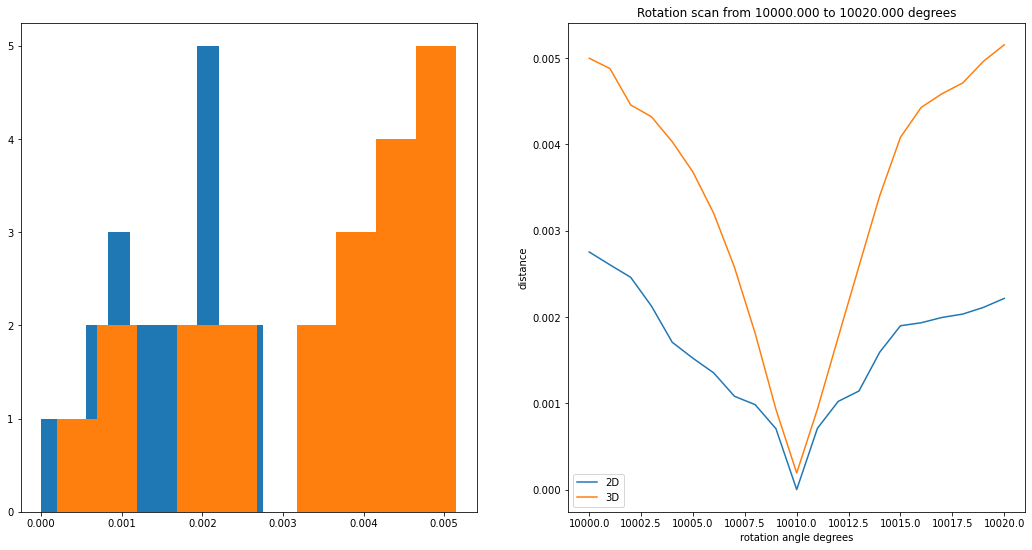

In [16]:
plotter.plot_distances_for_scan(my_geom_ids, distances_2d, distances_3d)

In [17]:
# Test rotation set
my_angles = [i*0.01 for i in range(-10, 11)]
r_set = geom.build_rotation_set('L2', 'y', my_angles, 20000)
r_set_frame = geom.concat_dicts(r_set)
r_set_frame.tail()

,geom_id,L1_dx,L1_dy,L1_dz,L1_rx,L1_ry,L1_rz,L2_dx,L2_dy,L2_dz,...,Filter_dz,Filter_rx,Filter_ry,Filter_rz,Detector_dx,Detector_dy,Detector_dz,Detector_rx,Detector_ry,Detector_rz
20016,20016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20017,20017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20018,20018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20019,20019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20020,20020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# run simulations for the set of geometries
r_beam_spots = run_and_analyze_simulation_for_geom_frame(r_set_frame, beam_config=BEAM_CONFIG_1)

Run simulation for geom id: 20000
Run simulation for geom id: 20001
Run simulation for geom id: 20002
Run simulation for geom id: 20003
Run simulation for geom id: 20004
Run simulation for geom id: 20005
Run simulation for geom id: 20006
Run simulation for geom id: 20007
Run simulation for geom id: 20008
Run simulation for geom id: 20009
Run simulation for geom id: 20010
Run simulation for geom id: 20011
Run simulation for geom id: 20012
Run simulation for geom id: 20013
Run simulation for geom id: 20014
Run simulation for geom id: 20015
Run simulation for geom id: 20016
Run simulation for geom id: 20017
Run simulation for geom id: 20018
Run simulation for geom id: 20019
Run simulation for geom id: 20020


In [19]:
# Compute distances for each frame
r_distances_2d = list()
r_distances_3d = list()
r_my_geom_ids = list()
for one in r_beam_spots:
    geom_id = one[0]
    df_i = one[1]
    r_my_geom_ids.append(geom_id)
    match_ref = match_ghosts(ref_data_frame, df_i)
    r_distances_2d.append(compute_2d_reduced_distance(match_ref))
    r_distances_3d.append(compute_reduced_distance(match_ref))


(<Figure size 1296x648 with 2 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:title={'center':'Rotation scan from 20000.000 to 20020.000 degrees'}, xlabel='rotation angle degrees', ylabel='distance'>],
       dtype=object))

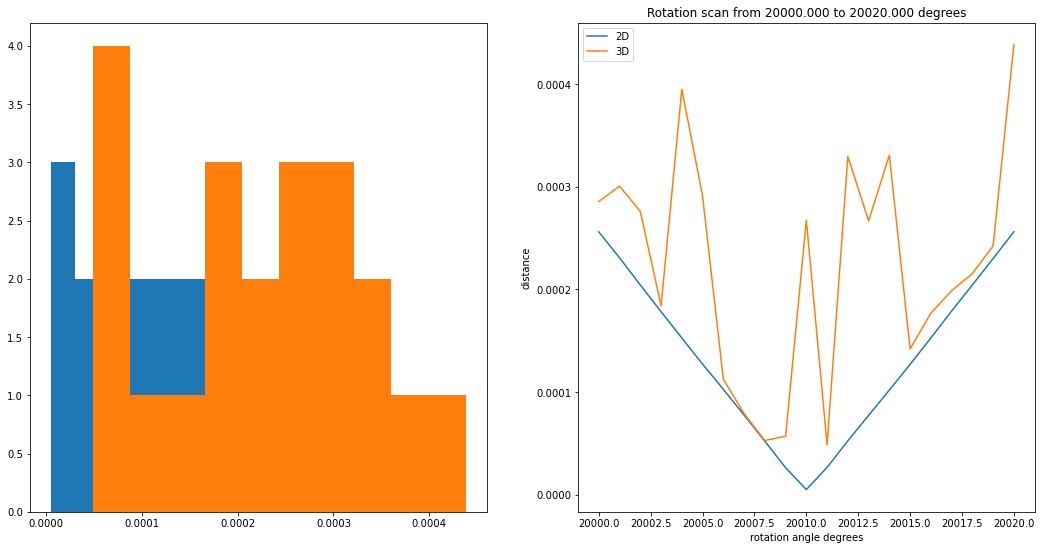

In [20]:
plotter.plot_distances_for_scan(r_my_geom_ids, r_distances_2d, r_distances_3d)